This notebook documents the steps involved in finding communities within the rural road network graph.

In [5]:
from sklearn.cluster import spectral_clustering
import config
import osmnx as ox
import networkx as nx
import numpy as np
import route_planning.helpers.community_detection_helper as helper

Load the graph of the Donegal road network which has had weights applied to its edges based on townland populations. 

In [33]:
graph_file = f"{config.graph_graphml_path}/donegal_osm_weights_applied.graphml"
G = ox.load_graphml(graph_file)
len(G.edges)

7252

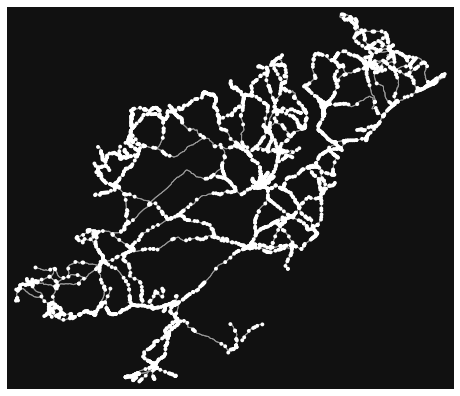

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7377b54ac0>)

In [34]:
ox.plot_graph(G)

There are some disconnected edges remaining in the bottom right of the graph so these should be removed  before clustering into communities.

For a directed graph a seperate list strongly/weakly connected components can be found.

Remove any set of connected components made up of fewer than 10 elements.

In [35]:
connected_strongly = list(nx.strongly_connected_components(G))
connected_weakly = list(nx.weakly_connected_components(G))

connected_components = connected_strongly + connected_weakly

# get any sets of nodes with less than 10 elements
few_connections = []
for c in connected_components:
    if len(c) < 10:
        few_connections.append(c)
# remove the nodes
for fc in few_connections:
    G.remove_nodes_from(fc)

No disconnected parts remain in the graph

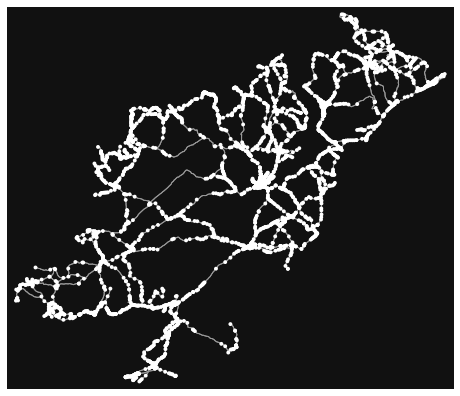

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f737e3378e0>)

In [36]:
ox.plot_graph(G)

Edge weights are loaded as strings so need to convert to numeric

In [37]:
weight_attributes = nx.get_edge_attributes(G, "weight")

weight_attributes = dict([k, {"weight": float(v)}]
                         for k, v in weight_attributes.items())
nx.set_edge_attributes(G, weight_attributes)
nx.get_edge_attributes(G, "weight")

{(2907242498, 1514179595, 0): 263.0,
 (2907242498, 2907242386, 0): 52.0,
 (780664835, 818377528, 0): 1.0,
 (780664835, 818371756, 0): 1.0,
 (1908244498, 1514190567, 0): 1.0,
 (1908244498, 1908450447, 0): 47.0,
 (3201138706, 1984055360, 0): 1.0,
 (3201138706, 3201138713, 0): 13.0,
 (3201138713, 3201138706, 0): 1.0,
 (3201138713, 1984054673, 0): 1.0,
 (1417674781, 2039160901, 0): 1.0,
 (1417674781, 1417674837, 0): 1.0,
 (1417674781, 258670217, 0): 1.0,
 (3151921209, 33246812, 0): 1.0,
 (3151921209, 33246802, 0): 1.0,
 (3112960060, 33194765, 0): 1.0,
 (3112960060, 3112960104, 0): 10.0,
 (911999040, 1435301486, 0): 1.0,
 (911999040, 1918824766, 0): 1.0,
 (821231682, 821216048, 0): 1.0,
 (821231682, 2907229653, 0): 1.0,
 (1908244553, 1908141366, 0): 1.0,
 (1908244553, 1908450663, 0): 1.0,
 (1417674837, 1417674841, 0): 1.0,
 (1417674837, 1417674781, 0): 1.0,
 (1417674837, 1556358443, 0): 1.0,
 (1417674841, 2001839630, 0): 1.0,
 (1417674841, 1417674837, 0): 1.0,
 (3112960104, 462923353, 0): 1

Get the weighted adjacency matrix

In [38]:
A = nx.to_numpy_array(G, weight="weight")
A

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0., 199.],
       [  0.,   0.,   0., ...,   0., 235.,   0.]])

In [42]:
len(A)

3579

Perform spectral clustering using the adjacency matrix. 

Find 18 clusters. 24 routes currently operated in Donegal by LocalLink (https://www.locallink.ie/en/timetables/regular-rural-services/). 

This is done so that a better connected bus network can be created, with 18 community routes and 6 connecting routes between the communities.

In [45]:
%%time
n_clust = 18
sc = spectral_clustering(A, n_clusters=n_clust)

/home/danny/College/donegal-bus-routes/venv1/lib/python3.8/site-packages/sklearn/utils/validation.py:73: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(**kwargs)
/home/danny/College/donegal-bus-routes/venv1/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


CPU times: user 7min 26s, sys: 5min 24s, total: 12min 50s
Wall time: 3min 23s


Apply community labels based on cluster assigned to each node during spectral clustering process.

In [46]:
len(sc)

3579

In [47]:
nx.set_node_attributes(G, 0, "community")
i = 0
for node in G.nodes:
    G.nodes[node]["community"] = sc[i]
    i += 1
G.nodes(data=True)

NodeDataView({2907242498: {'y': 54.8652516, 'x': -7.5081556, 'osmid': 2907242498, 'community': 15}, 780664835: {'y': 54.972684, 'x': -7.7090562, 'osmid': 780664835, 'community': 10}, 1908244498: {'y': 54.85721, 'x': -7.5405803, 'osmid': 1908244498, 'community': 15}, 3201138706: {'y': 54.6479035, 'x': -8.6183871, 'osmid': 3201138706, 'community': 4}, 3201138713: {'y': 54.6479279, 'x': -8.6214864, 'osmid': 3201138713, 'community': 4}, 1417674781: {'y': 55.2257747, 'x': -7.0858022, 'osmid': 1417674781, 'community': 1}, 3151921209: {'y': 54.6337503, 'x': -8.6474055, 'osmid': 3151921209, 'community': 4}, 3112960060: {'y': 54.5228223, 'x': -8.1558733, 'osmid': 3112960060, 'community': 17}, 911999040: {'y': 54.7766345, 'x': -8.316315, 'osmid': 911999040, 'community': 5}, 821231682: {'y': 54.9665332, 'x': -7.4597948, 'osmid': 821231682, 'community': 15}, 1908244553: {'y': 54.8561017, 'x': -7.635638, 'osmid': 1908244553, 'community': 2}, 1417674837: {'y': 55.2315345, 'x': -7.084004, 'osmid': 14

Plot the graph with coloured communities.

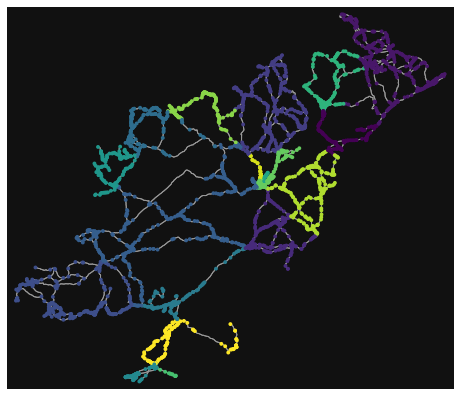

In [48]:
helper.plot_osmnx_graph_with_colour_coded_communities(G)

The graph has no disconnected parts now.

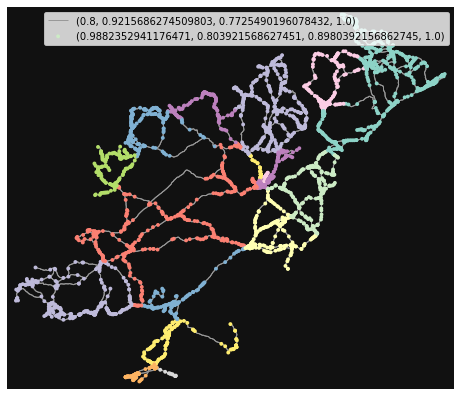

In [70]:
node_colours = ox.plot.get_node_colors_by_attr(G, attr="community", cmap="Set3")
fig, ax =  ox.plot_graph(G, node_color=node_colours, show=False, close=False)
ax.legend(node_colours.values)

In [72]:
node_colours

2907242498    (0.8, 0.9215686274509803, 0.7725490196078432, ...
780664835     (0.9882352941176471, 0.803921568627451, 0.8980...
1908244498    (0.8, 0.9215686274509803, 0.7725490196078432, ...
3201138706    (0.7450980392156863, 0.7294117647058823, 0.854...
3201138713    (0.7450980392156863, 0.7294117647058823, 0.854...
                                    ...                        
1445887976    (0.7019607843137254, 0.8705882352941177, 0.411...
1881571305    (0.984313725490196, 0.5019607843137255, 0.4470...
2114650088    (0.5529411764705883, 0.8274509803921568, 0.780...
1883209723    (0.984313725490196, 0.5019607843137255, 0.4470...
1883209727    (0.984313725490196, 0.5019607843137255, 0.4470...
Length: 3579, dtype: object

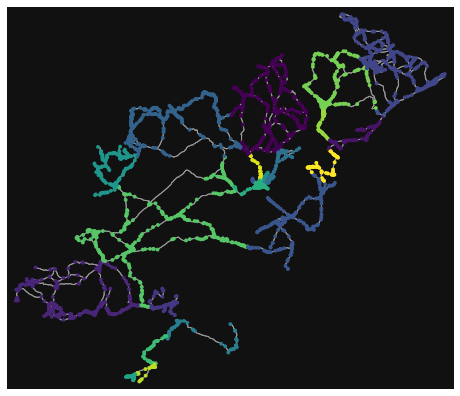

In [32]:
helper.plot_osmnx_graph_with_colour_coded_communities(G)


In [ ]:
helper.plot_osmnx_graph_with_colour_coded_communities(G)

array([ 8,  6,  0, ...,  5, 11, 11], dtype=int32)

In [49]:
np.save("../clusters/sc.npy", sc)

In [5]:
sc = np.load("../clusters/sc.npy")
sc_19 = np.load("../clusters/sc_19.npy")
sc_19_ = np.load("../clusters/sc_19_.npy")